## 2. Fasea: Algoritmoak diseinatzen

#### [Ikasle]

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, hiru algoritmo diseinatu beharko dituzue. Lehenengoa, algoritmo eraikitzaile bat izango da. Bigarrena, soluzio bakarrean oinarritutako heuristiko bat izan beharko du, eta azkenik, hirugarrena algoritmo poblazional bat izango da. Hiru algoritmoak estokastikoak izan beharko dute, eta horietatik, bik, oinarri probabilistikoa izan beharko dute. Adibidez, Simulated Annealing, Estimation of Distribution Algorithms (EDAk) edota Ant Colony Optimization (ACO) implementatu ditzazkezue. Proiektu honen kasuan, algoritmoen helburua, komunitate kopuru jakin bat emanik, modularitatea maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.

#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena fluxu diagrama eta sasikode bat egitea direla. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Azalpenak ere nahi ditut. Diagramak ez dira eurak bakarrik azaltzen, beraz testutik erreferentziatu egin beharko dituzue. Saiatu idazkera zientifiko-tekniko batekin idazten (pentsatu publikatuko duzuen lan bat dela). Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

---
Lehenik eta behin beharrezkoak diren  import-ak egingo ditugu:

In [22]:
from itertools import product
from ipynb.fs.full.CDP_Sarrera_Ikasle import sortu_grafoa 
from ipynb.fs.full.CDP_Sarrera_Ikasle import bistaratu_grafoa
from ipynb.fs.full.CDP_1_fasea_Ikasle import modularitatea1 
from ipynb.fs.full.CDP_1_fasea_Ikasle import kalkulatuHasierakoMAT
from ipynb.fs.full.CDP_1_fasea_Ikasle import modularitatea2
import community 
import networkx as nx
import numpy as np
import random as rm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 

Aldagai orokorrak hasieratuko ditugu:

In [23]:
G = sortu_grafoa()
m = G.size(weight='weight')
kalkulatuHasierakoMAT(G)

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3215


Funtzio orokorrak definituko ditugu:

In [34]:
 def partizioak_irudikatu(G, k):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)

    number_of_colors = k
    i, color = 0, []
    while i < number_of_colors:
        color_aux =[rm.choice('0123456789ABCDEF') for j in range(6)]
        if color_aux not in color:
            color.append("#"+''.join(color_aux))
            i += 1
             
    #kolore desberdinak izan behar dira
    assert(len(np.unique(color)) == number_of_colors)

    # Draw a subgraph, reusing the same node positions
    for i in range(k):
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
        nx.draw(G.subgraph(partizioa_elem),node_size = 20, pos=pos, node_color=color[i])

    plt.show()

    plt.axis('off')
    plt.show()

# Algoritmo eraikitzailea

In [15]:
def hasieraketa(G, k):
    auzokide_guztiak = {}
    for node in G:
        auzo_kop = len(G[node].items())
        auzokide_guztiak[node] = auzo_kop
    auzokide_guztiak = dict(sorted(auzokide_guztiak.items(), key=lambda x: x[1], reverse=True))
    #30% ausaz lehenengo erditik (konektatuenetatik)
    hasi_elem = rm.sample([key for key in auzokide_guztiak][:len(auzokide_guztiak)//2], k//3)
    #70% ausaz bigarren erditik (gutxiago konektatuetatik)
    hasi_elem += rm.sample([key for key in auzokide_guztiak][len(auzokide_guztiak)//2:],k- k//3)
    return hasi_elem

def aukeratu_onena(G, partizioa_elem, aztertuak, weight):
    maxim, elem_max = -float('inf'), None
    for elem in partizioa_elem:
        kv = G.degree(elem, weight=weight)
        for nbr, eattr in G[elem].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            if nbr not in aztertuak: #ez baldin bada aztertua izan
                wt = eattr[weight] #n eta nbr arteko pisuak
                kw = G.degree(nbr, weight=weight)
                batu = wt - (kv * kw)/(2*m)
                if batu > maxim:
                    maxim = batu
                    elem_max = nbr
    return elem_max

def partizio_partziala(G, k, partizioa,weight, aztertutakoak):
    eguneratu = True
    while eguneratu: 
        for i in range(k): #partizio bakoitzeko
            partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
            elem_onena = aukeratu_onena(G, partizioa_elem, aztertutakoak, weight)
            if elem_onena == None:
                eguneratu = False
            else:
                eguneratu = True
                aztertutakoak.append(elem_onena)
                partizioa[elem_onena] = i
    return partizioa, aztertutakoak

def partizio_onenean_sartu(G, k, partizioa, weight, node):
    maxim, partizio_onena, elem_max = -float('inf'), None, None
    for i in range(k): #partizio bakoitzeko
        batu = 0
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak        
        for elem in partizioa_elem:
            kv = G.degree(elem, weight=weight)
            kw = G.degree(node, weight=weight)
            batu += - (kv * kw)/(2*m) #Avw = 0 izango da ez daudelako konketatuta
        if batu > maxim:
            maxim = batu
            partizio_onena = i
    partizioa[node] = partizio_onena #sartu 
    return partizioa
    
#partizio bakoitzean egongo diren idazleak ausaz aukeratuko dira
def algoritmo_eraikitzailea(G, k, weight= 'weight'):
    #hasi_elem = rm.sample([node for node in G], k) #aukeratu k ausaz
    hasi_elem = hasieraketa(G,k)
    aztertutakoak =[] 
    partizioa = {}
    kont = 0
    eguneratu = True
    for elem in hasi_elem: #sartu elementu bakoitza partizio batean
        aztertutakoak.append(elem)
        partizioa[elem] = kont
        kont += 1
    #sortutako lehenengo partizioa aukeratutako elementuekin. Partizioetan dauden elementuak konektata daude
    lehenengo_partizioa, aztertutakoak = partizio_partziala(G, k, partizioa, weight, aztertutakoak)
    #partizioen barruko elementuekin konektatu gabeko elementuak gehitu behar ditugu
    for node in G:
        if node not in aztertutakoak: #ez baldin bada aztertu
            partizioa = partizio_onenean_sartu(G, k, partizioa, weight, node)
            aztertutakoak.append(node)#igual kendu??
    
    return partizioa

In [16]:
k = 200
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
#modularitatea kalkulatuko dugu
print("1. soluzioaren modularitatea: ", modularitatea1(G, partizioa))
print("1. soluzioaren modularitatea: ", modularitatea2(G, partizioa))
#inprimaru partizioa
print(partizioa)

1. soluzioaren modularitatea:  0.14098601961882287
1. soluzioaren modularitatea:  0.13640065825411624
{'Ryan Kiros': 0, 'James Ridgway': 1, 'Jean Philippe Avouac': 2, 'Shuhang Gu': 3, 'Shaul Markovitch': 4, 'Dimitris Papailiopoulos': 5, 'Aaron C. Courville': 6, 'Yann LeCun': 7, 'Tian Lin': 8, 'Xiaojin Zhu': 9, 'Jayadev Acharya': 10, 'Jonathan Chang': 11, 'Viktoriia Sharmanska': 12, 'Quanquan Gu': 13, 'Quoc V. Le': 14, 'james m. robins': 15, 'Tom Gunter': 16, 'Praneeth Netrapalli': 17, 'Jost Springenberg': 18, 'Sashank J. Reddi': 19, 'Xinying Song': 20, 'Sham M. Kakade': 21, 'Francisco Ruiz': 22, 'Lasse Espeholt': 23, 'Risi Kondor': 24, 'Xiaolong Wang': 25, 'Leo K?rkk?inen': 26, 'Dinggang Shen': 27, 'Mohamed Osama Ahmed': 28, 'Pradeep K. Ravikumar': 29, 'Murat Kocaoglu': 30, 'J. D. Tygar': 31, 'Branislav Kveton': 32, 'Chiyuan Zhang': 33, 'Kevin G. Jamieson': 34, 'Ahmed Hefny': 35, 'Richard E. Turner': 36, 'Julie A. Shah': 37, 'Rajesh Ranganath': 38, 'Judy Hoffman': 39, 'Sherjil Ozair': 

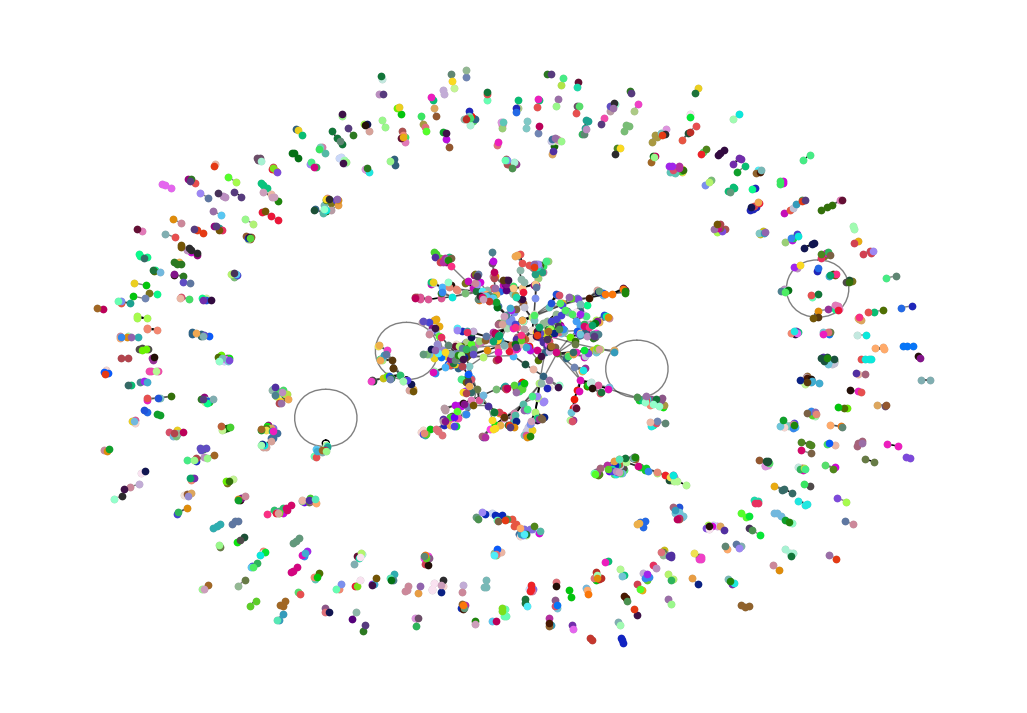

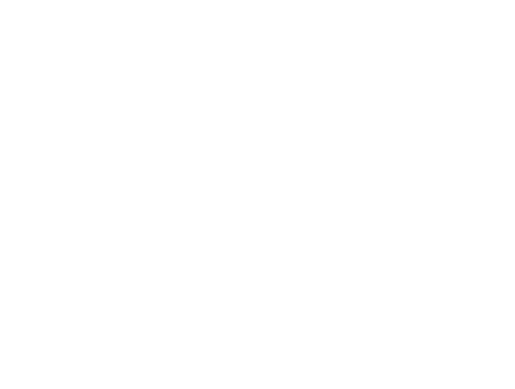

In [35]:
partizioak_irudikatu(G, k)

['Alex Kulesza', 'Masashi Sugiyama', 'Sham M. Kakade', 'Anqi Wu', 'Will Kay', 'Jonathan W. Pillow', 'Russell Poldrack', 'Anthony D. Joseph', 'Edwin V. Bonilla', 'Charlie Frogner', 'Ian Goodfellow', 'Lei Wang', 'Salomon Diether', 'David Woodruff', 'Stefan Huber', 'Bharath Sriperumbudur', 'Constantinos Daskalakis', 'Tomi Silander', 'Nisheeth Srivastava', 'Fangjian Guo', 'Vikas Sindhwani', 'Koosha Khalvati', 'Aurelien Lucchi', 'John Wright', 'Xu Chen', 'Hal Daume III', 'Tasuku Soma', 'Simon Rubinstein-Salzedo', 'Bernd G?rtner', 'Gergo Bohner', 'Yuri Grinberg', 'Mohammad E. Khan', 'Kevin Moon', 'Lucas Theis', 'Aditya Khosla', 'Gheorghe Comanici', 'Ruoyu Sun', 'Pascal Fua', 'Dharmashankar Subramanian', 'Maximilian Nickel', 'Xin Liu', 'Jennifer Chayes', 'Michail Kontitsis', 'Haim Cohen', 'Alfred Hero', 'Chao Qu', 'Timothy A. Mann', 'Anastasia Pentina', 'Hiroshi Nakagawa', 'Maria Lomeli']
861


### Erreferentziak
https://medium.com/smucs/girvan-newman-v-louvain-for-community-detection-33988baab55b  
https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008/pdf  
https://www.nature.com/articles/s41598-019-41695-z  
https://www.cwts.nl/blog?article=n-r2u2a4   
https://i11www.iti.kit.edu/_media/teaching/theses/ba-nguyen-21.pdf  
https://github.com/taynaud/python-louvain/blob/master/community/community_louvain.py  